# Trading Day Data Visualization

#### 1) minute chart data from finance.yahoo

In [1]:
from urllib.parse import urlencode
from datetime import datetime, timedelta
import pandas as pd
import requests
import pytz
import json

def get_minute_data(symbol, now):
    
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    end = start.replace(hour=13, minute=0)  
    base_url = "https://l4-query.finance.yahoo.com/v7/finance/chart/{}".format(symbol)
    params = dict(
        period1=int(start.timestamp()),
        period2=int(end.timestamp()),
        interval="1m",
        indicators="quote",
        includeTimestamps="true",
        includePrePost="true",
        events="div%7Csplit%7Cearn",
        corsDomain="finance.yahoo.com"
    )
    url = "{}?{}".format(base_url, urlencode(params))
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    resp_tz = pytz.timezone(data['meta']['timezone'])
    df = pd.DataFrame(quote, index=[datetime.fromtimestamp(t, tz=resp_tz).astimezone(now.tzinfo) for t in times])
    return df


la_tz = pytz.timezone('America/Los_Angeles')
now = datetime.now(tz=la_tz) - timedelta(days=1)
minute_data = get_minute_data('BAC', now)
minute_data

,close,high,low,open,volume
2017-02-21 06:30:00-08:00,24.629999,24.629999,24.590000,24.590000,0
2017-02-21 06:31:00-08:00,24.670000,24.670000,24.629900,24.629999,639535
2017-02-21 06:32:00-08:00,24.680000,24.690001,24.660000,24.663500,621285
2017-02-21 06:33:00-08:00,24.690001,24.726999,24.680000,24.680000,600485
2017-02-21 06:34:00-08:00,24.714899,24.715000,24.693501,24.693501,442190
2017-02-21 06:35:00-08:00,24.660000,24.713699,24.650000,24.713699,487716
2017-02-21 06:36:00-08:00,24.713499,24.713499,24.660000,24.660000,411632
2017-02-21 06:37:00-08:00,24.709999,24.710100,24.674999,24.710100,390680
2017-02-21 06:38:00-08:00,24.700001,24.730000,24.700001,24.711599,422407
2017-02-21 06:39:00-08:00,24.725000,24.725000,24.700001,24.705000,170353


/usr/local/lib/python3.4/dist-packages/matplotlib-2.0.0b4_3022.gdfd38f7-py3.4-linux-x86_64.egg/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


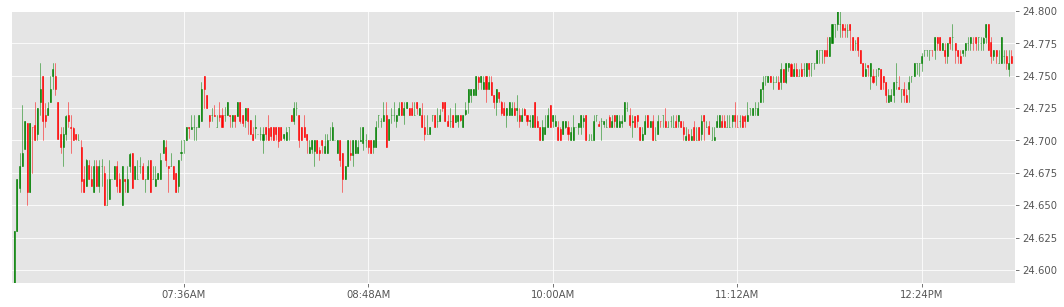

In [2]:
from matplotlib.finance import *
import matplotlib.pyplot as plt
from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
    
style.use('ggplot')

def plot_minute_data(data):
    if data is not None:
        fig = plt.figure(figsize=(18, 5))
        ax = plt.subplot(111)
        candlestick_ochl(
            ax, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) 
             for r in data.itertuples()), 
            width=1/3600,  
            colorup='g',  
            colordown='r',
        )

        x_min, x_max = date2num(data.index.min()) - .001, date2num(data.index.max()) + .001
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(data.low.min(), data.high.max())

        minute_formatter = DateFormatter('%I:%M%p', tz=pytz.timezone('America/Los_Angeles'))
        ax.xaxis.set_major_formatter(minute_formatter)

        ax.yaxis.tick_right()
        plt.show()

plot_minute_data(minute_data)

#### 2) the trade lot data from nasdaq.com

In [6]:
from urllib.parse import quote_plus, urlparse, parse_qs
from lxml import html, etree
import queue
import requests
import threading
import re

PROXIES = [
    
    '45.32.101.246:3128', '144.217.128.207:8080', '37.72.100.61:3128', '177.67.82.25:80', 
    '178.32.220.216:3128', '149.56.102.14:8080',  '45.55.207.152:3128', '104.224.37.5:3128', 
    '212.47.242.86:3128',  '172.82.144.10:3128','144.217.15.249:8080', '207.154.201.156:3128', 
    '138.97.241.160:3128', '40.138.64.36:8080',  '121.135.146.184:8080','104.196.249.237:80', 
    '177.54.152.155:80', '104.197.82.38:80', '96.65.123.249:8118', '104.196.229.130:80', 
    '46.105.121.118:1080', '104.196.177.247:80', '158.69.187.67:8080', '172.82.144.11:3128', 
    '177.67.82.12:8080', '159.203.146.38:8080', '200.199.203.177:80', '83.239.58.162:8080',  
    '204.12.155.204:3128', '149.56.233.61:8080', '125.31.19.26:80', '192.187.100.29:3128', '5.2.73.71:1080', 
    '103.243.141.43:80', '163.121.188.2:8080', '218.161.1.189:3128', '128.199.73.229:8080', 
    '163.121.188.3:8080', '186.179.109.77:8080', '138.201.63.123:31288', '96.239.193.243:8080', 
    '51.254.221.166:3128', '36.66.63.180:3128', '193.171.90.2:8080', '91.98.94.112:80', 
    '5.2.73.231:1080', '37.187.100.23:3128', '192.148.69.102:8080', '58.97.81.11:80', 
    '46.29.119.20:3128', '61.93.131.51:8998', '23.88.102.25:8080', '196.202.255.66:80', 
    '118.70.197.68:8080', '115.249.2.192:8080', '23.88.102.24:8080', '35.166.171.212:3128', 
    '95.54.76.231:8080', '203.162.234.60:58315', '178.161.149.18:3128', '52.59.57.135:8083', 
    '192.99.120.40:80', '94.154.57.5:9999', '80.241.217.251:3128', '118.165.191.45:8998', 
    '94.177.231.20:8080', '216.56.81.209:8080', '5.63.152.21:8118', '185.58.227.184:3128', 
    '185.28.193.95:8080', '83.169.229.51:8080', '217.33.216.114:8080', '62.255.116.73:8080', 
    '175.45.57.11:8080', '54.172.23.233:8083', '183.179.231.118:9999', '5.2.64.150:1080', 
    '54.153.62.91:9999', '12.33.254.195:3128', '155.94.213.135:8118', '95.170.202.110:8080', 
    '89.164.96.233:80', '153.149.166.219:3128', '49.205.246.59:8080', '5.2.75.15:1080',
    
    '89.40.121.243:80', '54.206.70.173:8083', '85.220.189.18:9090', '5.85.63.32:3128',
    '94.177.188.246:3128', '89.45.249.224:8080', '178.62.251.9:3128', '158.69.68.191:8080',
    '89.34.26.14:1080', '5.160.139.180:3128','217.150.54.177:8080', '85.220.189.21:9090', 
    '103.68.34.140:8080', '40.79.79.194:3128', '179.185.54.114:8080',
]

NUM_THREADS = 40


class ProxyFailException(Exception):
    pass    

def load_in_parrallel(*args, now, scrap_func, save_func, time=1, page=1, offset=0):   
    
    tasks = queue.Queue() # queue with arguments for the 'get_transactions' function
    responses = queue.Queue() # queue with raw responses  
    proxies = queue.Queue()
    for p in PROXIES:
        proxies.put(p)
        
    def get_proxy():
        try:
            proxy = proxies.get_nowait()
        except queue.Empty:        
            pass
            #print("Error: you have used all the proxies - this worker will stop")
        else:    
            return proxy
    
    def worker():        
        proxy = get_proxy()        
        while proxy is not None:            
            args, kwargs = tasks.get()
            if args is None:
                break   
            while True:
                try:
                    scrap_func(proxy, tasks, responses, *args, **kwargs)
                except ProxyFailException as e:
                    proxy = get_proxy()
                    if proxy is None:
                        tasks.put((args, kwargs))  # put the task back and die
                        break                    
                else:
                    break   
            tasks.task_done()
    

    threads = []
    for i in range(NUM_THREADS):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)
        
    tasks.put((args, dict(time=time, page=page, offset=offset)))

    # block until all tasks are done
    tasks.join()

    # stop workers
    for i in range(NUM_THREADS):
        tasks.put((None, None))

    for t in threads:
        t.join()
        
    return save_func(responses, now)

def pull_trades(proxy, q, r, stock, pageno=None, time=1, page=1, offset=0):
    base_url = "http://www.nasdaq.com/symbol/{symbol}/time-sales?time={time}&pageno={pageno}"
    get_page = pageno or page
    url = base_url.format(symbol=stock, time=time, pageno=get_page)
    try:
        page_res = requests.get(url, timeout=6, proxies={'http': "http://{}".format(proxy)})
    except Exception as e:
        raise ProxyFailException()
        
    else:    
        tree = html.fromstring(page_res.content)

        if pageno is None:
            pager = tree.find('.//ul[@id="pager"]')
            if pager is not None:
                page_links = pager.findall('.//a')
                if page_links:
                    href = page_links[-1].attrib['href']
                    parsed_url = urlparse(href)
                    query_params = parse_qs(parsed_url.query)
                    max_page = int(query_params['pageno'][0])
                    for pn in range(page + 1, max_page + 1):                    
                        q.put(((stock, pn), dict(time=time, page=page, offset=offset)))
            else:
                raise ProxyFailException('The pager is missing')
                

        table = tree.find('.//table[@id="AfterHoursPagingContents_Table"]')
        if table is None:
            raise ProxyFailException('The table is missing')
        else:
            lots = [
                tuple(col.text_content() for col in row) 
                for row in table 
                if row.tag == 'tr'
            ]
            if get_page == page and offset:
                lots = lots[offset:]
            
            for l in lots:
                r.put(l)
            
def save_trades(r, now):
    df = pd.DataFrame([], columns=('Time', 'Price', 'Volume'))
    i = 0
    while True:
        try:
            time, price, volume = r.get(block=False)
        except queue.Empty:
            break
        else:
            df.loc[i] = re.sub(r'[^\d:]+', '', time), float(re.sub(r'[^\d\.]+', '', price)), int(re.sub(r'[^\d]+', '', volume))
            i += 1
    return df

In [7]:
def get_trade_lots(symbol, now, time=1, page=1, offset=0):    
    df = load_in_parrallel(symbol, now=now, scrap_func=pull_trades, save_func=save_trades, 
                           time=time, page=page, offset=offset)    
    df['Minute'] = df.Time.str[:5]
    df['Cost'] = df.Price * df.Volume * 100    
    df = df.sort_values(by=['Time'], ascending=False)
    return df

df = get_trade_lots('BAC', now)
df

,Time,Price,Volume,Minute,Cost


In [16]:
# This function will display the table
from IPython.display import display, HTML
from datetime import datetime
import math


def display_trade_lots_tables(data, minute_data, now):
    if data is None or not len(data):
        print("Trade lots list is empty")
        return
    data['Count'] = 1      
    def apply_minute_data(df):
        eastern = pytz.timezone('US/Eastern')
        def get_minute_data(row):
            minute = row.Minute if 'Minute' in df.dtypes.keys() else row.name 
            hour, minute = minute.split(':')
            time = now.replace(hour=int(hour), minute=int(minute), second=0, microsecond=0, tzinfo=eastern)
            time = datetime(
                now.year, now.month, now.day, 
                hour=int(hour), minute=int(minute), second=0, microsecond=0,
            )        
            time = eastern.localize(time)

            if minute_data is not None:
                md = minute_data.loc[time]
                open, close = md.open, md.close
            else:
                open = close = None        
            return open, close    

        df['Open'], df['Close'] = zip(*df.apply(get_minute_data, axis=1))
        df['CloseByOpen'] = (df.Close / df.Open - 1) * 100
    
    def display_table(rows):
        headers = ("Time", "Open", "Close", "Close/Open", "Shares", "Cost", "# of lots")
        row = "<td>{time}</td><td>{open:.4f}</td><td>{close:.4f}</td>"\
              "<td>{close_by_open:.4f}</td>"\
              "<td>{volume:,.0f}</td><td>{cost:,.0f}</td><td>{count}</td>"
        table_rows = (row.format(**kwargs) for kwargs in rows) 
        display(
            HTML(
                '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format(
                    "</th><th>".join(headers),
                    "</tr><tr>".join(table_rows)
                )
            )
        )  
    
    
    display(HTML("<h4>AGGREGATED TRADING FEED BY MINUTE</h4>"))
    sum_data = data.groupby(['Minute'])['Cost', 'Volume', 'Count'].sum()
    apply_minute_data(sum_data)
    sum_data = sum_data.sort_index(ascending=False)
    
#     def get_tab(value, max_value, color):
#         n = math.ceil(value / max_value * 10) 
#         return '<div style="float:left;background-color:{};height=20px;" >{}</div>'.format(
#             "green" if color >= 0 else "red",
#             "&nbsp;" * n, 
#         )
#     max_close_by_open = sum_data.CloseByOpen.max()
    rows = (dict(time=r.Index, open=r.Open, close=r.Close, 
                 close_by_open=r.CloseByOpen, #co_tab=get_tab(r.CloseByOpen, max_close_by_open, r.CloseByOpen),
                 volume=r.Volume, cost=r.Cost, count=r.Count) 
            for r in sum_data.itertuples())
    display_table(rows)
    
    display(HTML("<h4>SEGREGATED TRADING FEED BY MINUTE</h4>"))
    apply_minute_data(data)
    #max_close_by_open = data.CloseByOpen.max()
    rows = (dict(time=r.Minute, open=r.Open, close=r.Close, 
                 close_by_open=r.CloseByOpen, #co_tab=get_tab(r.CloseByOpen, max_close_by_open, r.CloseByOpen),
                 volume=r.Volume, cost=r.Cost, count=r.Count)
            for r in data.itertuples())
    display_table(rows)
    
    
#     return sum_data 

display_trade_lots_tables(df, minute_data, now)

Trade lots list is empty


In [ ]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from matplotlib import ticker, dates as mdates
import numpy as np
import pytz
from time import sleep
import heapq
import math

tz = pytz.timezone('America/Los_Angeles')
STOCK_SYMBOL = 'BAC'

last_time = None
trade_lots = None
lots_times = (
    (6, 59),
    (7, 29),
    (7, 59),
    (8, 29),
    (8, 59),
    (9, 29),
    (9, 59),
    (10,29),
    (10, 59),
    (11, 29),
    (11, 59),
    (12, 29),
    (13, 0),
)
last_lots_loaded = dict(time=1, page=1, offset=0)


while True:    
    now = datetime.now(tz=tz)
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    stop = start.replace(hour=13, minute=0)
    
    if start <= now <= stop: # proper time for getting data
        
        if last_time: # no more often than once per minute
            diff = 60 - (now - last_time).seconds            
            if diff > 0:
                sleep(diff)
        
        # GETTING DATA
        minute_data = get_minute_data(STOCK_SYMBOL, now)        
        
        leh, lem = lots_times[last_lots_loaded['time'] - 1]
        time_range_end = start.replace(hour=leh, minute=lem)
        if last_time and last_time > time_range_end:
            last_lots_loaded = dict(time=last_lots_loaded['time'] + 1,  page=1, offset=0)

        response = get_trade_lots(STOCK_SYMBOL, now, **last_lots_loaded)
        res_len = len(response)
        page, offset = math.ceil((res_len + 1) / 50), res_len % 50
        if page > last_lots_loaded['page']:
            last_lots_loaded['page'] = page
        if offset > last_lots_loaded['offset']:
            last_lots_loaded['offset'] = offset
            
        
        if res_len:
            response = response[response.Volume >= 1000]
            if trade_lots is not None:
                trade_lots = trade_lots.append(response, ignore_index=True)
            else:
                trade_lots = response

        # DISPLAYING DATA
        clear_output()
        print('1) minute chart data from finance.yahoo')
        plot_minute_data(minute_data)
        
        print('2) the trade lot data from nasdaq.com')
        display_trade_lots_tables(trade_lots, minute_data, now)    
        
        print("last update", now)
        print("prev update", last_time) 
        print("update time", datetime.now(tz=tz) - now)
        last_time = now        
    else:        
        last_lots_loaded = dict(time=1, page=1, offset=0)
        trade_lots = None
        
        if now < start:
            diff = start - now
            print("time to start:", diff)
            
        else:
            start_tommorow = start + timedelta(days=1)
            print("start tommorow at", start_tommorow)
            diff = start_tommorow - now
        
        sleep(diff.seconds + diff.microseconds * 0.1 ** 6)

time to start: 2:42:56.464873
